# 1. Imports

In [1]:
import os, json, cv2, numpy as np, matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F
from torchvision.transforms import transforms as transforms

# Library for augmentations
import albumentations as A

# https://github.com/pytorch/vision/tree/main/references/detection
import transforms, utils, engine, train
from utils import collate_fn
from engine import train_one_epoch, evaluate

# 2. Augmentations

In [2]:
def train_transform():
    return A.Compose([
        A.Sequential([
            # Random rotation
            A.augmentations.geometric.rotate.Rotate(limit=10, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=1),
            # Random change of brightness and contrast
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, brightness_by_max=True, always_apply=False, p=1),
        ], p=1)
    ],
    # More about keypoint formats used in albumentations library read at https://albumentations.ai/docs/getting_started/keypoints_augmentation/
    keypoint_params=A.KeypointParams(format='xy'),
    # Bboxes should have labels, read more here https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['bboxes_labels'])
    )

# 3. Dataset class

In [3]:
class ClassDataset(Dataset):
    def __init__(self, root, transform=None, demo=False):                
        self.root = root
        self.transform = transform
        # Use demo=True if you need transformed and original images (for example, for visualization purposes)
        self.demo = demo
        self.imgs_files = sorted(os.listdir(os.path.join(root, 'images')))
        self.annotations_files = sorted(os.listdir(os.path.join(root, 'annotations')))
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, 'images', self.imgs_files[idx])
        annotations_path = os.path.join(self.root, 'annotations', self.annotations_files[idx])

        img_original = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        with open(annotations_path) as f:
            data = json.load(f)
            bboxes_original = data['bboxes']
            keypoints_original = data['keypoints']
            
            # All objects are car wheels
            bboxes_labels_original = ['Car wheel' for _ in bboxes_original]            

        if self.transform:   
            # Converting keypoints from [x, y, visibility]-format to [x, y]-format + Flattening nested list of keypoints            
            # For example, if we have the following list of keypoints for three objects (each object has two keypoints):
            # [[obj1_kp1, obj1_kp2, obj1_kp3], [obj2_kp1, obj2_kp2, obj2_kp3], [obj3_kp1, obj3_kp2, obj3_kp3]], where each keypoint is in [x, y]-format            
            # Then we need to convert it to the following list:
            # [obj1_kp1, obj1_kp2, obj1_kp3, obj2_kp1, obj2_kp2, obj2_kp3, obj3_kp1, obj3_kp2, obj3_kp3]
            keypoints_original_flattened = [el[0:2] for kp in keypoints_original for el in kp]

            # Apply augmentations
            transformed = self.transform(image=img_original, bboxes=bboxes_original, bboxes_labels=bboxes_labels_original, keypoints=keypoints_original_flattened)
            img = transformed['image']
            bboxes = transformed['bboxes']
            
            # Unflattening list transformed['keypoints']
            # For example, if we have the following list of keypoints for three objects (each object has two keypoints):
            # [obj1_kp1, obj1_kp2, obj1_kp3, obj2_kp1, obj2_kp2, obj2_kp3, obj3_kp1, obj3_kp2, obj3_kp3], where each keypoint is in [x, y]-format
            # Then we need to convert it to the following list:
            # [[obj1_kp1, obj1_kp2, obj1_kp3], [obj2_kp1, obj2_kp2, obj2_kp3], [obj3_kp1, obj3_kp2, obj3_kp3]]
            keypoints_transformed_unflattened = np.reshape(np.array(transformed['keypoints']), (-1, 3, 2)).tolist()

            # Converting transformed keypoints from [x, y]-format to [x, y, visibility]-format by appending original visibilities to transformed coordinates of keypoints
            keypoints = []
            for o_idx, obj in enumerate(keypoints_transformed_unflattened):
                obj_keypoints = []
                for k_idx, kp in enumerate(obj): # Iterating over keypoints in each object
                    # kp - coordinates of keypoint
                    # keypoints_original[o_idx][k_idx][2] - original visibility of keypoint
                    obj_keypoints.append(kp + [keypoints_original[o_idx][k_idx][2]])
                keypoints.append(obj_keypoints)
        
        else:
            img, bboxes, keypoints = img_original, bboxes_original, keypoints_original        
        
        # Convert everything into a torch tensor        
        bboxes = torch.as_tensor(bboxes, dtype=torch.float32)       
        target = {}
        target['boxes'] = bboxes
        # All objects are car wheels
        target['labels'] = torch.as_tensor([1 for _ in bboxes], dtype=torch.int64)
        target['image_id'] = torch.tensor([idx])
        target['area'] = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
        target['iscrowd'] = torch.zeros(len(bboxes), dtype=torch.int64)
        target['keypoints'] = torch.as_tensor(keypoints, dtype=torch.float32)        
        img = F.to_tensor(img)
        
        bboxes_original = torch.as_tensor(bboxes_original, dtype=torch.float32)
        target_original = {}
        target_original['boxes'] = bboxes_original
        # All objects are car wheels
        target_original['labels'] = torch.as_tensor([1 for _ in bboxes_original], dtype=torch.int64)
        target_original['image_id'] = torch.tensor([idx])
        target_original['area'] = (bboxes_original[:, 3] - bboxes_original[:, 1]) * (bboxes_original[:, 2] - bboxes_original[:, 0])
        target_original['iscrowd'] = torch.zeros(len(bboxes_original), dtype=torch.int64)
        target_original['keypoints'] = torch.as_tensor(keypoints_original, dtype=torch.float32)        
        img_original = F.to_tensor(img_original)

        if self.demo:
            return img, target, img_original, target_original
        else:
            return img, target
    
    def __len__(self):
        return len(self.imgs_files)

# 4. Visualizing a random item from dataset

In [4]:
keypoints_classes_ids2names = {0: 'Top', 1: 'Bottom', 2: 'Right'}

def visualize(image, bboxes, keypoints, image_original=None, bboxes_original=None, keypoints_original=None):
    fontsize = 18
    
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    if image_original is not None:
        image_original = cv2.cvtColor(image_original, cv2.COLOR_GRAY2RGB)

    for bbox in bboxes:
        start_point = (bbox[0], bbox[1])
        end_point = (bbox[2], bbox[3])
        image = cv2.rectangle(image.copy(), start_point, end_point, (0,255,0), 2)
    
    for kps in keypoints:
        for idx, kp in enumerate(kps):
            image = cv2.circle(image.copy(), tuple(kp), 5, (255,0,0), 10)
            image = cv2.putText(image.copy(), ' ' + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3, cv2.LINE_AA)

    if image_original is None and keypoints_original is None:
        plt.figure(figsize=(40,40))
        plt.imshow(image)

    else:
        for bbox in bboxes_original:
            start_point = (bbox[0], bbox[1])
            end_point = (bbox[2], bbox[3])
            image_original = cv2.rectangle(image_original.copy(), start_point, end_point, (0,255,0), 2)
        
        for kps in keypoints_original:
            for idx, kp in enumerate(kps):
                image_original = cv2.circle(image_original, tuple(kp), 5, (255,0,0), 10)
                image_original = cv2.putText(image_original, ' ' + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3, cv2.LINE_AA)

        f, ax = plt.subplots(1, 2, figsize=(40, 20))

        ax[0].imshow(image_original)
        ax[0].set_title('Original image', fontsize=fontsize)

        ax[1].imshow(image)
        ax[1].set_title('Transformed image', fontsize=fontsize)

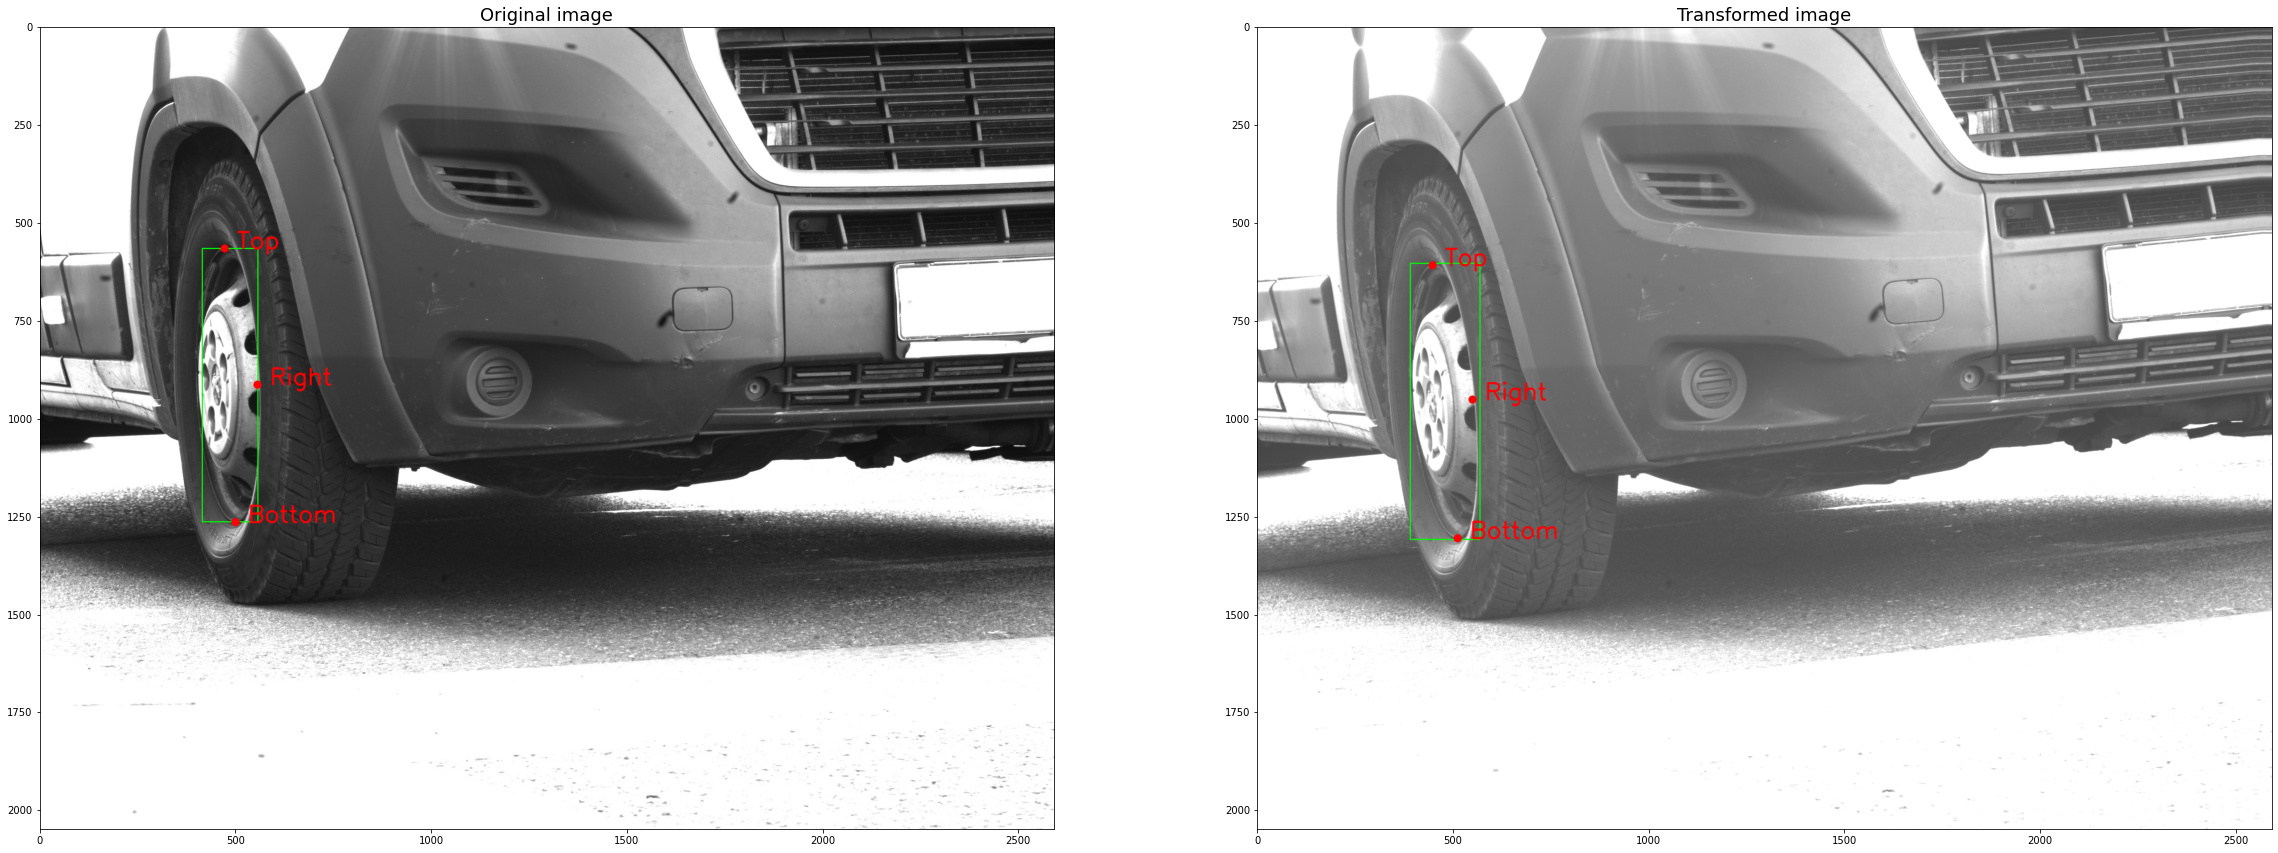

In [6]:
KEYPOINTS_FOLDER_TRAIN = 'dataset/train'
dataset = ClassDataset(KEYPOINTS_FOLDER_TRAIN, transform=train_transform(), demo=True)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

iterator = iter(data_loader)
batch = next(iterator)    
    
image = (batch[0][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes = batch[1][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints = []
for kps in batch[1][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints.append([kp[:2] for kp in kps])

image_original = (batch[2][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes_original = batch[3][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints_original = []
for kps in batch[3][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints_original.append([kp[:2] for kp in kps])

visualize(image, bboxes, keypoints, image_original, bboxes_original, keypoints_original)

# 5. Training

In [7]:
def get_model(num_keypoints, weights_path=None):
    anchor_generator = AnchorGenerator(sizes=(32, 64, 128, 256, 512), aspect_ratios=(0.25, 0.5, 0.75, 1.0, 2.0, 3.0, 4.0))
    model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=False,
                                                                   pretrained_backbone=True,
                                                                   num_keypoints=num_keypoints,
                                                                   # One class for car wheel, one class for background
                                                                   num_classes=2,
                                                                   rpn_anchor_generator=anchor_generator)
    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)        
        
    return model

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

KEYPOINTS_FOLDER_TRAIN = 'dataset/train'
KEYPOINTS_FOLDER_TEST = 'dataset/test'

dataset_train = ClassDataset(KEYPOINTS_FOLDER_TRAIN, transform=train_transform(), demo=False)
dataset_test = ClassDataset(KEYPOINTS_FOLDER_TEST, transform=None, demo=False)

data_loader_train = DataLoader(dataset_train, batch_size=1, shuffle=True, collate_fn=collate_fn)
data_loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)

model = get_model(num_keypoints=3)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)
num_epochs = 50

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=100)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device)
    
# Save model weights after training
torch.save(model.state_dict(), 'saved_model.pth')

# 6. Visualizing model predictions

In [8]:
# Load model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = get_model(num_keypoints=3)
model.to(device)

model.load_state_dict(torch.load('saved_model.pth', map_location=device))
model.eval()

KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(640, 672, 704, 736, 768, 800), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, 

/home/daniel/.local/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Confidence: 0.73
Keypoints: [[122, 638], [135, 1182], [199, 904]]
Bounding box: [34, 608, 213, 1184]


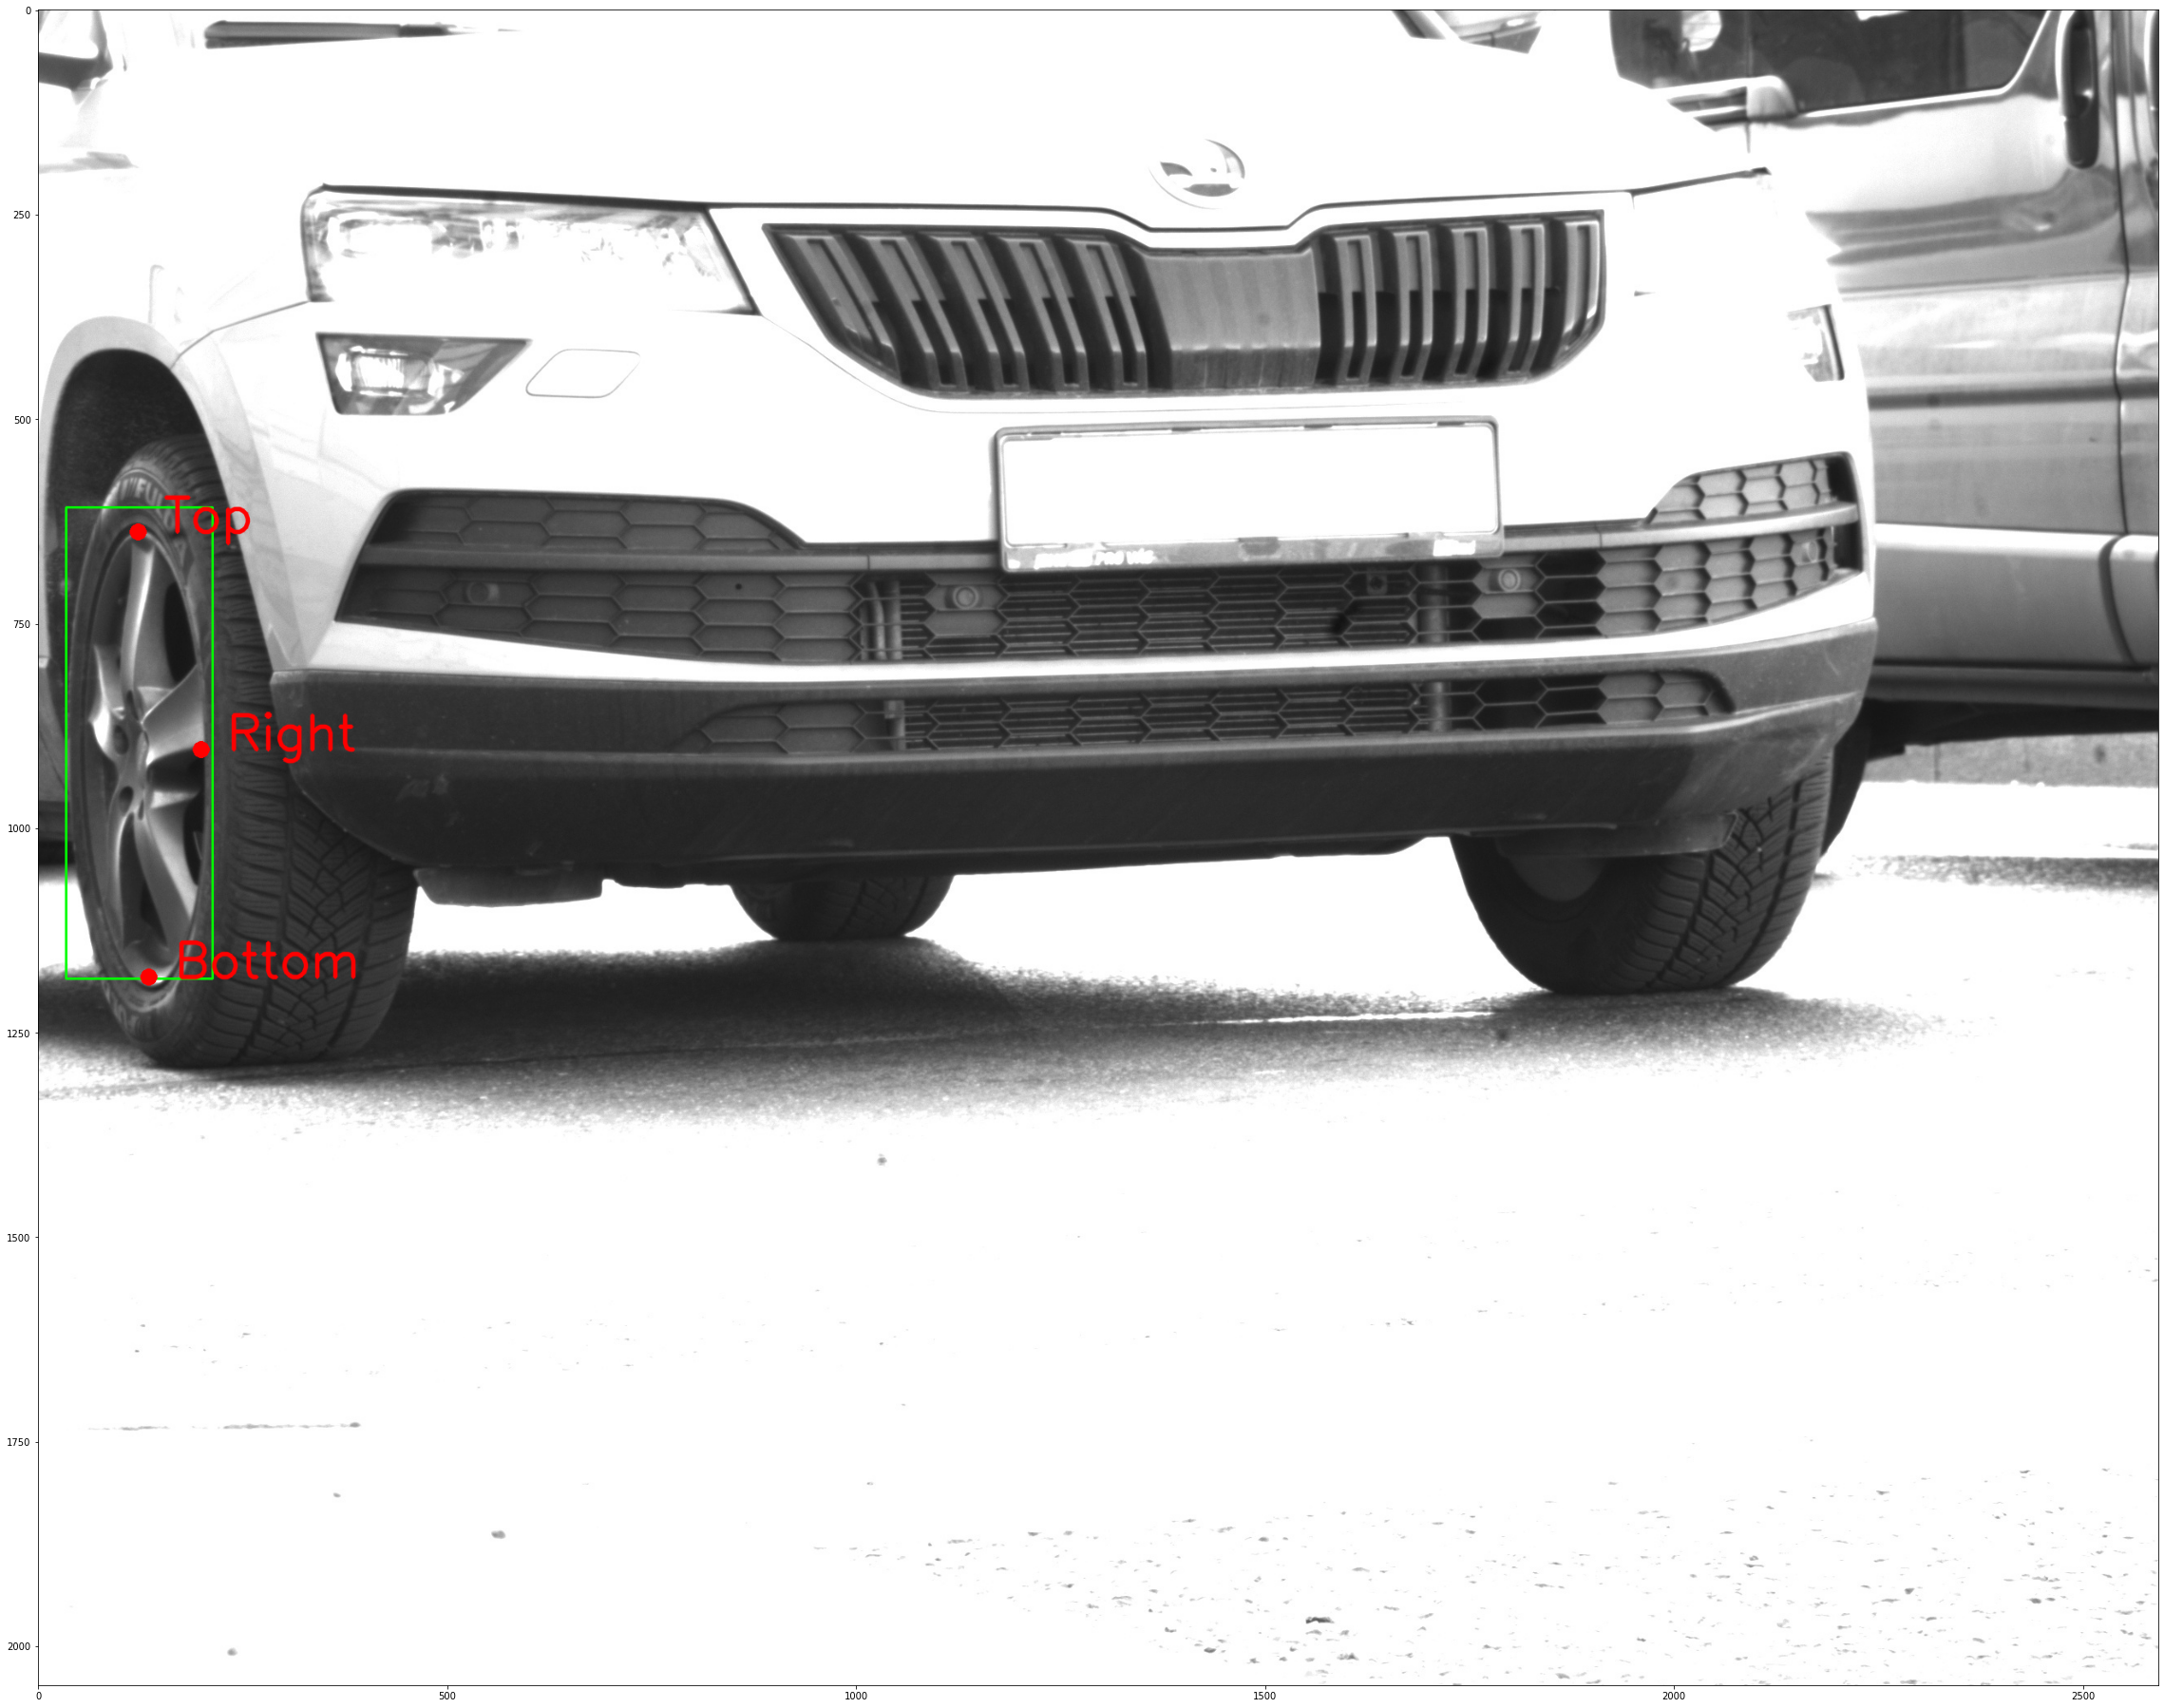

In [9]:
# Load image
image_path = 'dataset/test/images/001.jpg'
original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
# Convert to tensor
image = F.to_tensor(original_image)
# Add batch dimension
image = image.unsqueeze(0).to(device)

# Turn off context manager for gradient calculation (memory saving)
with torch.no_grad():
    output = model(image)

scores = output[0]['scores'].detach().cpu().numpy()

if len(scores) == 0:
    print('No hits')
else:
    # Detections are sorted by score, highest is first
    best = 0
    print(f'Confidence: {scores[best]:.2f}')
    # If you desire to find multiple car wheels, not just the best one, then you have to use NMS to eliminate
    # overlapping objects (because second best object might be referring to the same car wheel, just with less
    # confidence), see https://pytorch.org/vision/main/generated/torchvision.ops.nms.html

    # Get keypoints and bounding box from output
    keypoints = []
    for point in output[0]['keypoints'][best].detach().cpu().numpy():
        keypoints.append([int(point[0]), int(point[1])])

    bbox = [int(i) for i in output[0]['boxes'][best].detach().cpu().numpy()]

    print(f'Keypoints: {keypoints}')
    print(f'Bounding box: {bbox}')

    visualize(original_image, [bbox], [keypoints])